[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/final/execution.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/ai-unibo-nlp-project/blob/main/final/execution.ipynb)
[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/Danysan1/ai-unibo-nlp-project/tree/main/final/execution.ipynb)

# Final project

## Imports and Initial Settings

In [ ]:
%pip install pandas numpy matplotlib transformers dataset

In [ ]:
import numpy as np
import random
import torch
import pandas as pd
from os import path
from sklearn.model_selection import train_test_split
import random
import gc
import torch
import transformers
from tqdm import tqdm
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [ ]:
# Fix the random state to 42
SEED = 42

def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_seed(SEED)

## Dataset Loading

In [ ]:
data_folder = 'Dataset'

def load__dataset(filename:str) -> pd.DataFrame:
    with open(path.join(data_folder, filename)) as file_obj:
        data = pd.read_json(file_obj, dtype={'episode':str,'speakers':np.array})
        return data

In [ ]:
training_set_fn = 'MELD_train_efr.json'

dataset = load__dataset(training_set_fn)
dataset.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


In [ ]:
def get_index_none_triggers(df:pd.DataFrame, column:str) -> list:
    has_none = []
    for i in df[column].index:
        is_none = np.where(np.array(df[column][i]) == None, 1, 0).any()
        if is_none:
            has_none.append(i)
    return has_none

def clean_none(df:pd.DataFrame, column:str, indexes:list) -> pd.DataFrame:
    for i in indexes:
        df[column][i] = [el if el is not None else 0.0 for el in df[column][i]]
    return df

Check how many triggers do have a None value.

In [ ]:
indexes_none = get_index_none_triggers(dataset, column='triggers')
print("{} trigger rows have None values.\n".format(len(indexes_none)))
if len(indexes_none) > 0:
    print(dataset['triggers'][indexes_none])

9 trigger rows have None values.

2671                                [0.0, 0.0, 1.0, None]
2693                      [0.0, 0.0, 0.0, 0.0, 1.0, None]
3105    [0.0, 0.0, 0.0, None, 0.0, 0.0, 0.0, 1.0, 1.0,...
3157    [0.0, 0.0, None, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...
3171    [0.0, 0.0, 0.0, 0.0, 0.0, None, 0.0, 0.0, 1.0,...
3204    [None, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3266    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, None, 0.0, 1.0,...
3351    [0.0, 0.0, 0.0, None, 0.0, 0.0, 0.0, 0.0, 0.0,...
3359    [0.0, None, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: triggers, dtype: object


Now we clean the dataset and then check the previous lists.

In [ ]:
dataset = clean_none(dataset, column='triggers', indexes=indexes_none)
indexes_none_clean = get_index_none_triggers(dataset, column='triggers')
print("\nAfter cleaning, {} trigger rows have None values.\n".format(len(indexes_none_clean)))
if len(indexes_none) > 0:
    print(dataset['triggers'][indexes_none])


After cleaning, 0 trigger rows have None values.

2671                                 [0.0, 0.0, 1.0, 0.0]
2693                       [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
3105    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...
3157    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
3171    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
3204    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3266    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
3351    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3359    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: triggers, dtype: object


##Data Elaboration

###Preprocessing

In [ ]:
tot = len(dataset)
data = []
for r in range(tot):
  text = dataset['utterances'][r]
  em = dataset['emotions'][r]
  trig = dataset['triggers'][r]
  for i in range(1,len(text)+1):
    t = []
    for q in range(i):
      t.append(text[q])
    #convert the list t into a string
    string = " ".join(map(str,t))
    data.append(
        {'episode': dataset['episode'][r],
        'utterance': string,
        'emotion': em[i-1],
        'trigger': trig[i-1]
              })
data = pd.DataFrame(data)

In [ ]:
len(data)

35000

<Axes: >

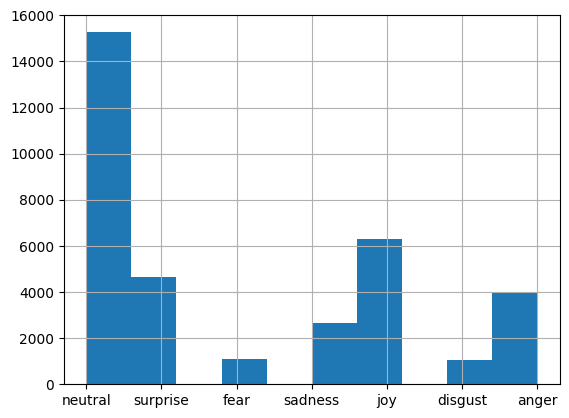

In [ ]:
data['emotion'].hist()

This shows that the data is imbalanced.

In [ ]:
len(data)

35000

In [ ]:
episodes = data['episode'].unique()

###Label Encoder

In [ ]:
#label encoder
from sklearn.preprocessing import LabelEncoder
le_emo = LabelEncoder()
data['labemo'] = le_emo.fit_transform(data['emotion'])
le_tri = LabelEncoder()
data['labtri'] = le_tri.fit_transform(data['trigger'])

In [ ]:
data['emotion'].unique()

array(['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust',
       'anger'], dtype=object)

In [ ]:
data['labemo'].unique()

array([4, 6, 2, 5, 3, 1, 0])

### Train-Val-Test splitting

In [ ]:
idx_train, idx_test = train_test_split(episodes,
                                     random_state=SEED,
                                     test_size=0.1)
idx_train, idx_val = train_test_split(idx_train,
                                     random_state=SEED,
                                     test_size=idx_test.shape[0])
df_train = data[data['episode'].isin(idx_train)]
df_test = data[data['episode'].isin(idx_test)]
df_val = data[data['episode'].isin(idx_val)]
print('Number of training samples: {}'.format(df_train.shape[0]))
print('Number of test samples: {}'.format(df_test.shape[0]))
print('Number of validation examples: {}'.format(df_val.shape[0]))

Number of training samples: 27850
Number of test samples: 3612
Number of validation examples: 3538


In [ ]:
df_train.head()

,episode,utterance,emotion,trigger,labemo,labtri
0,utterance_0,also I was the point person on my company's tr...,neutral,0.0,4,0
1,utterance_0,also I was the point person on my company's tr...,neutral,0.0,4,0
2,utterance_0,also I was the point person on my company's tr...,neutral,0.0,4,0
3,utterance_0,also I was the point person on my company's tr...,neutral,1.0,4,1
4,utterance_0,also I was the point person on my company's tr...,surprise,0.0,6,0


In [ ]:
df_test.head()

,episode,utterance,emotion,trigger,labemo,labtri
55,utterance_8,"Hey, Mon.",neutral,0.0,4,0
56,utterance_8,"Hey, Mon. Hey-hey-hey. You wanna hear somethin...",neutral,0.0,4,0
57,utterance_8,"Hey, Mon. Hey-hey-hey. You wanna hear somethin...",joy,0.0,3,0
58,utterance_8,"Hey, Mon. Hey-hey-hey. You wanna hear somethin...",sadness,1.0,5,1
77,utterance_12,"Hey, Mon.",neutral,0.0,4,0


## Utils

### Pytorch Dataset

In [ ]:
class CreateDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

###Model

In [ ]:
from transformers import DistilBertModel, BertModel
import torch.nn as nn

class CustomBERTModel(nn.Module):

    def __init__(self,checkpoint, num_labels_emo, num_labels_tri):
          super(CustomBERTModel, self).__init__()
          self.num_labels_emo = num_labels_emo
          self.num_labels_tri = num_labels_tri
          self.model = model = BertModel.from_pretrained(checkpoint)
          ### New layers:
          self.dropout = nn.Dropout(0.3)
          self.cls_emo = nn.Linear(self.model.config.hidden_size, num_labels_emo)
          self.cls_tri = nn.Linear(self.model.config.hidden_size, num_labels_tri)

    def forward(self, input_ids, attention_mask):
          output = self.model(
               input_ids,
               attention_mask=attention_mask)
          #sequence_output = output[0]
          #print(sequence_output.shape)
          #the pooler output contains the information
          pooler_output = output.pooler_output
          x = self.dropout(pooler_output)
          x_emo = self.cls_emo(x)
          x_tri = self.cls_tri(x)

          return x_emo, x_tri

In [ ]:
def getModel(model_checkpoint, num_labels_emo, num_labels_tri):

  model = CustomBERTModel(model_checkpoint, num_labels_emo, num_labels_tri)
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)

  return model, tokenizer

###Training

In [ ]:
# Train one epoch
def train(model: torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          device: torch.device,
          optimizer: torch.optim,
          criterion: torch.nn.Module,
          epoch: int) -> float:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.
        optimizer: the optimizer to use to train the model.
        epoch: the number of the current epoch.

    Returns:
        the cross entropy Loss value on the training data.
    """
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)
    loss_score = []
    loop = tqdm(train_loader)
    #set training mode
    model.train()
    for idx_batch, batch in enumerate(loop):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_emo = batch['labels_emo'].to(device)
        labels_tri = batch['labels_tri'].to(device)
        #print(f"target-size: {labels.shape}")
        logits_emo, logits_tri = model(input_ids,
                                        attention_mask=attention_mask,
                                    )
        #print(f"logits-size: {logits.shape}")
        loss_emo = criterion(logits_emo, labels_emo)
        loss_tri = criterion(logits_tri, labels_tri)
        loss = loss_emo + loss_tri
        loss_score.append(loss.item())
        loss.backward()
        optimizer.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    loss_train = np.mean(loss_score)
    return loss_train

# Validate one epoch
def validate(model: torch.nn.Module,
             criterion: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             device: torch.device) -> float:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation data.
        device: the device to use to evaluate the model.

    Returns:
        the loss value on the validation data.
    """
    loss_score = []
    #set evaluation mode
    model = model.eval()
    with torch.no_grad():
        for idx_batch, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_emo = batch['labels_emo'].to(device)
            labels_tri = batch['labels_tri'].to(device)
            logits_emo, logits_tri = model(input_ids,
                                            attention_mask=attention_mask,
                                        )
            loss_emo = criterion(logits_emo, labels_emo)
            loss_tri = criterion(logits_tri, labels_tri)
            loss = loss_emo + loss_tri
            loss_score.append(loss.item())
    loss_val = np.mean(loss_score)
    return loss_val

In [ ]:
def training_loop(num_epochs: int,
                  optimizer: torch.optim,
                  criterion: torch.nn.Module,
                  model: torch.nn.Module,
                  loader_train: torch.utils.data.DataLoader,
                  loader_val : torch.utils.data.DataLoader = None,
                  verbose: bool=True) -> Dict:
    """Executes the training loop.

        Args:
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the validation loss for each epoch.
            the time of execution in seconds for the entire loop.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    loop_start = timer()
    train_losses_values = []
    val_losses_values = []
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train = train(model, loader_train, device,
                                           optimizer, criterion, epoch)
        if(loader_val != None):
          loss_val = validate(model, criterion, loader_val, device)
        else:
          loss_val = 0
        time_end = timer()
        train_losses_values.append(loss_train)
        val_losses_values.append(loss_val)
        if verbose:
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}')

    return {'train_loss_values': train_losses_values,
            'val_loss_values' : val_losses_values,
            'time': time_loop}

###Execution

In [ ]:
def execute(lr: float,
            num_epochs: int,
            batch_size: int,
            criterion: torch.nn.Module,
            num_labels_emo: int,
            num_labels_tri: int,
            data: pd.DataFrame,
            data_labels_emo: pd.DataFrame,
            data_labels_tri: pd.DataFrame,
            val_df: pd.DataFrame,
            val_labels_emo: pd.DataFrame,
            val_labels_tri: pd.DataFrame,
            cross_val: bool=False,
            model_name="",
            model=None,
            tokenizer=None
            ) ->Tuple[torch.nn.Module, any]:
    """Gets the model, does the encodings of the training and validation data using the
        tokenizer, and then executes the training loop.

    Args:
        lr: the learning rate.
        num_epochs: the number of epochs.
        batch_size: the batch size.
        data: training-val dataframe.
        data_labels: training-val labels dataframe.
        val_df: validation dataframe.
        model: the network to train.
        history: questions-answers history flag.
    """

    #print(model)
    if(cross_val):
      #cross validation, consider the validation size as about 20% of the training data
      k = 5
      fold_size = len(data) // k
      validation_scores = []
      #shuffle the data before start training
      idx = list(range(0,len(data)))
      np.random.shuffle(idx)
      shuffled_data = data.iloc[idx,:]
      shuffled_labels_emo = data_labels_emo.iloc[idx,:]
      shuffled_labels_tri = data_labels_tri.iloc[idx,:]
      print(f'STARTING TRAINING with {k}-CROSS-VAL:')
      for i in range(0,k):
        val_data = shuffled_data[i*fold_size:(i+1)*fold_size]
        val_data_labels_emo = shuffled_labels_emo[i*fold_size:(i+1)*fold_size]
        val_data_labels_tri = shuffled_labels_tri[i*fold_size:(i+1)*fold_size]
        train_data = pd.concat([shuffled_data[:i*fold_size],shuffled_data[(i+1)*fold_size :]], ignore_index=True)
        train_data_labels_emo = pd.concat([shuffled_labels_emo[:i*fold_size],shuffled_labels_emo[(i+1)*fold_size :]], ignore_index=True)
        train_data_labels_tri = pd.concat([shuffled_labels_tri[:i*fold_size],shuffled_labels_tri[(i+1)*fold_size :]], ignore_index=True)
        #get the model and the tokenizer
        if not model_name == "":
          model, tokenizer = getModel(model_name, num_labels_emo, num_labels_tri)
        #Start encodings
        #print(f'STARTING ENCODING:')
        #print(f'Train set:')
        train_encodings = encode(tokenizer, train_data, train_data_labels_emo, train_data_labels_tri)
        #print(f'Validation set:')
        val_encodings = encode(tokenizer, val_data, val_data_labels_emo, val_data_labels_tri)
        #print(f'ENCODING COMPLETE.')

        #create training dataset
        train_dataset = CreateDataset(train_encodings)
        #create training dataloader
        data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle = True
                                            )
        #create validation dataset
        val_dataset = CreateDataset(val_encodings)
        #create validation dataloader
        data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle = False
                                            )

        #Optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1.5e-2)

        statistics = training_loop(num_epochs, optimizer, criterion, model,
                                  data_loader_train, data_loader_val)
        validation_score = np.mean(statistics['val_loss_values'])
        validation_scores.append(validation_score)
      #final val score
      val_score = np.average(validation_scores)
      print(f"Validation_score: {val_score}")
      print(f'Cross validation complete.')
    #train on full data

    #get the model and the tokenizer
    if not model_name == "":
      model, tokenizer = getModel(model_name, num_labels_emo, num_labels_tri)
    #Start encodings
    #print(f'Train set:')
    train_encodings = encode(tokenizer, data, data_labels_emo, data_labels_tri)
    if(not cross_val):
      #print(f'Validation set:')
      val_encodings = encode(tokenizer, val_df, val_labels_emo, val_labels_tri)
    print(f'ENCODING COMPLETE.')

    #create training dataset
    train_dataset = CreateDataset(train_encodings)
    #create training dataloader
    data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle = True
                                        )
    #create validation dataset
    if(cross_val):
      data_loader_val = None

    else:
      val_dataset = CreateDataset(val_encodings)
      #create validation dataloader
      data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=batch_size,
                                          shuffle = False
                                          )
    #Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1.5e-2)
    print(f'STARTING TRAINING with complete data:')
    statistics = training_loop(num_epochs, optimizer, criterion, model,
                              data_loader_train, data_loader_val)
    print(f'TRAINING COMPLETE.')

    return model, tokenizer, statistics

In [ ]:
def evaluate(model, criterion, data_loader, device):
  average_loss = []
  predictions = []
  model.eval()
  model.to(device)
  first = True
  loop = tqdm(data_loader)
  with torch.no_grad():
    for batch in loop:
      target_emo = batch['labels_emo'].to(device)
      target_tri = batch['labels_tri'].to(device)
      prediction_emo, prediction_tri = model(batch['input_ids'].to(device), attention_mask = batch["attention_mask"].to(device))
      predictions.append((prediction_emo, prediction_tri))
      loss_emo = criterion(prediction_emo,target_emo)
      loss_tri = criterion(prediction_emo,target_tri)
      loss = loss_emo + loss_tri
      average_loss.append(loss.item())

  loss = np.mean(average_loss)
  print(f"\naverage loss on val set: {loss}")

  return predictions

###Encoding

In [ ]:
def encode(tokenizer, df, labels_emo, labels_tri):
    #premise , stance, conclusion  --> premise, stance + conclusion
    #append the stance to the conclusion by putting a separator between them
  encodings = tokenizer(list(df['utterance']),
                          padding=True,
                          truncation=True,
                          max_length = 250,
                          )
  input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
  print(f"input shape: {np.shape(input_ids)}")
  encodings.update({'labels_emo' : torch.LongTensor(labels_emo.values)})
  encodings.update({'labels_tri' : torch.LongTensor(labels_tri.values)})
  encodings.pop('token_type_ids')
  return encodings

In [ ]:
#model_checkpoint= 'prajjwal1/bert-tiny'
#model_checkpoint = "distilbert-base-uncased"
model_checkpoint = 'bert-base-uncased'
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#eos_token  = tokenizer.cls_token_id
#sep_token  = tokenizer.sep_token_id

##Model training

In [ ]:
#parameters
lr = 5e-5
batch_size = 32
epochs = 2
cross_val = False
criterion = torch.nn.CrossEntropyLoss()

if you want to pass to the model the whole training set, change the code below

In [ ]:
fast_and_small = True

num_labels_emo = len(df_train['labemo'].unique())
num_labels_tri = len(df_train['labtri'].unique())

if fast_and_small:
    df_train = df_train[:2000]
    df_val = df_val[:1000]

df_train_labels_emo = df_train['labemo']
df_train_labels_tri = df_train['labtri']
df_val_labels_emo = df_val['labemo']
df_val_labels_tri = df_val['labtri']

In [ ]:
#execute
model, tokenizer, statistics = execute(lr, epochs, batch_size, criterion, num_labels_emo, num_labels_tri, df_train, df_train_labels_emo, df_train_labels_tri, df_val, df_val_labels_emo, df_val_labels_tri, cross_val = cross_val, model_name=model_checkpoint)

input shape: (2000, 250)
input shape: (1000, 250)
ENCODING COMPLETE.
STARTING TRAINING with complete data:


  0%|          | 0/63 [00:00<?, ?it/s]<ipython-input-105-4004cf27e00a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 63/63 [01:18<00:00,  1.25s/it, loss=2.01]


Epoch: 1  Lr: 0.00005000  Loss: Train = [1.9981] - Val = [1.7510]  Time one epoch (s): 92.8132 


Epoch 2: 100%|██████████| 63/63 [01:18<00:00,  1.25s/it, loss=1.43]


Epoch: 2  Lr: 0.00005000  Loss: Train = [1.3676] - Val = [1.6155]  Time one epoch (s): 92.4003 
Time for 2 epochs (s): 185.215
TRAINING COMPLETE.


## Evaluation

In [ ]:
#df_test_small = df_test
df_test_labels_emo = df_test['labemo']
df_test_labels_tri = df_test['labtri']

In [ ]:
test_encodings = encode(tokenizer, df_test, df_test_labels_emo, df_test_labels_tri)
#create training dataset
test_dataset = CreateDataset(test_encodings)
#create training dataloader
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle = False
                                        )

input shape: (3612, 250)


In [ ]:
model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
test_pred_emo = []
test_pred_tri = []
with torch.no_grad():
    for step_num, batch in tqdm(enumerate(test_dataloader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_emo = batch['labels_emo'].to(device)
        labels_tri = batch['labels_tri'].to(device)
        output = model(input_ids, attention_mask=attention_mask,
                        )
        p_emo, p_tri = output
        p_emo = p_emo.cpu().detach().numpy()
        p_tri = p_tri.cpu().detach().numpy()
        test_pred_emo.append(np.argmax(p_emo,axis=-1))
        test_pred_tri.append(np.argmax(p_tri,axis=-1))
test_pred_emo = np.concatenate(test_pred_emo)
test_pred_tri = np.concatenate(test_pred_tri)

0it [00:00, ?it/s]<ipython-input-105-4004cf27e00a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
113it [00:50,  2.23it/s]


In [ ]:
print(test_pred_emo[:100])
print(test_pred_tri[:100])

[4 4 3 5 4 4 3 5 6 4 1 5 4 4 3 5 6 4 1 5 4 4 6 6 6 4 4 4 4 4 3 6 4 4 4 4 4
 3 3 3 4 3 6 3 4 3 6 3 4 4 4 3 4 6 0 3 6 3 4 4 4 3 4 6 0 0 0 4 4 3 4 3 4 4
 3 4 3 4 6 6 6 4 4 3 4 3 4 6 6 6 4 4 3 2 4 4 4 6 4 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
df_test.loc[:,('predicted_emo')] = test_pred_emo
df_test.loc[:,('predicted_tri')] = test_pred_tri
df_test.head(5)

<ipython-input-121-7e80347b6373>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,('predicted_emo')] = test_pred_emo
<ipython-input-121-7e80347b6373>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,('predicted_tri')] = test_pred_tri


,episode,utterance,emotion,trigger,labemo,labtri,predicted_emo,predicted_tri
55,utterance_8,"Hey, Mon.",neutral,0.0,4,0,4,0
56,utterance_8,"Hey, Mon. Hey-hey-hey. You wanna hear somethin...",neutral,0.0,4,0,4,0
57,utterance_8,"Hey, Mon. Hey-hey-hey. You wanna hear somethin...",joy,0.0,3,0,3,0
58,utterance_8,"Hey, Mon. Hey-hey-hey. You wanna hear somethin...",sadness,1.0,5,1,5,0
77,utterance_12,"Hey, Mon.",neutral,0.0,4,0,4,0


#### Reports
Evaluate the models by using the Sequence F1 and the Unrolled Sequence F1 scores.

In [ ]:
from sklearn.metrics import f1_score

def sequence_f1(data: pd.DataFrame):
  '''input data has columns: episode, utterance, emotion, trigger, labemo, labtri, predicted_emo, predicted_tri
      ground truth:   labemo, labtri
      predicted:      predicted_emo, predicted_tri

      we calculate the F1 scores dialog-wise, and then return the average'''

  scores_emo = []
  scores_tri = []

  for ep in data['episode'].unique():
    ep_data = data[data['episode'] == ep]

    y_true = ep_data['labemo']
    y_pred = ep_data['predicted_emo']
    # TODO: I don't like -> data['labemo'].unique() => we should change it
    scores_emo.append(f1_score(y_true, y_pred, labels=data['labemo'].unique(), average='micro'))

    y_true = ep_data['labtri']
    y_pred = ep_data['predicted_tri']
    # TODO: I don't like -> data['labemo'].unique() => we should change it
    scores_tri.append(f1_score(y_true, y_pred, labels=data['labtri'].unique(), average='micro'))
  return np.mean(scores_emo), np.mean(scores_tri)

def unrolled_f1(data: pd.DataFrame):
  '''input data has columns: episode, utterance, emotion, trigger, labemo, labtri, predicted_emo, predicted_tri
      ground truth:   labemo, labtri
      predicted:      predicted_emo, predicted_tri

      we calculate the F1 scores on the whole dataset'''
  y_true = data['labemo']
  y_pred = data['predicted_emo']
  # TODO: I don't like -> data['labemo'].unique() => we should change it
  # TODO: Is it ok if we do 'macro' average?
  f1_emotion = f1_score(y_true, y_pred, labels=data['labemo'].unique(), average='macro')

  y_true = data['labtri']
  y_pred = data['predicted_tri']
  # TODO: I don't like -> data['labemo'].unique() => we should change it
  # TODO: Is it ok if we do 'macro' average?
  f1_trigger = f1_score(y_true, y_pred, labels=data['labtri'].unique(), average='macro')
  return f1_emotion, f1_trigger


In [ ]:
print("F1 score report - BERT Fully fine-tuned")
print()
print("Average Sequence F1 score")
s_e, s_t = sequence_f1(df_test)
print("- - Emotion average F1 Score:\t{}".format(s_e))
print("- - Triggers average F1 Score:\t{}".format(s_t))
s_e, s_t = unrolled_f1(df_test)
print()
print("Unrolled Sequence F1 score")
print("- - Emotion average F1 Score:\t{}".format(s_e))
print("- - Triggers average F1 Score:\t{}".format(s_t))

F1 score report - BERT Fully fine-tuned

Average Sequence F1 score
- - Emotion average F1 Score:	0.5849516309139365
- - Triggers average F1 Score:	0.8043115055706209

Unrolled Sequence F1 score
- - Emotion average F1 Score:	0.3396269745186263
- - Triggers average F1 Score:	0.47646103896103903


#### Majority Classifier

In [ ]:
def update_count_dictionary(key:str, d_em:dict):
    ''' Given in input a dictionary and a string key, it counts the times
        that key has been added.'''
    if key in d_em.keys():
        d_em[key] += 1
    else:
        d_em[key] = 1

emotions_dict = dict()

[update_count_dictionary(emotion, emotions_dict) for emotion in df_train['emotion']]
emotions_dict

{'neutral': 12055,
 'surprise': 3728,
 'fear': 910,
 'sadness': 2121,
 'joy': 5040,
 'disgust': 852,
 'anger': 3144}

In [ ]:
class Majority_Classifier():
    '''It is trained on a dataset using the emotion and trigger columns.
        It's output on the forward method will be always the majority class
        for emotion and trigger, calculated in the training set.'''

    def __init__(self):
        self.emotion = ""
        self.trigger = 0.0

    def train(self, dataset:pd.DataFrame):
        '''Input a dataset with the emotion and trigger columns.'''

        emotions_count = dict()
        triggers_count = dict()

        for em, tr in dataset[['emotion','trigger']].values:
            update_count_dictionary(em, emotions_count)
            update_count_dictionary(tr, triggers_count)

        # get the majority class for the emotion column
        max_count = -1
        for emotion, value in emotions_count.items():
            if value > max_count:
                max_count = value
                self.emotion = emotion

        # get the majority class for the trigger column
        max_count = -1
        for trigger, value in triggers_count.items():
            if value > max_count:
                max_count = value
                self.trigger = trigger

    def forward(self, utterance):
        '''The input is ignored. This method can be modified. It is intended to
            mimic the forward method of an ML model such that it usable in the same way.'''
        return self.emotion, self.trigger


dumb_majority = Majority_Classifier()
dumb_majority.train(df_train)

print("The majority emotion is: {}".format(dumb_majority.emotion))
print("The majority trigger is: {}".format(dumb_majority.trigger))
print()
print("A test for the dumb majority classifier:")
print("\t\tinput: Oh God! I'm dumb..")

e, t = dumb_majority.forward("Oh God! I'm dumb..")
print("\t\toutput: emotion:{}, trigger:{}".format(e,t))

The majority emotion is: neutral
The majority trigger is: 0.0

A test for the dumb majority classifier:
		input: Oh God! I'm dumb..
		output: emotion:neutral, trigger:0.0


In [ ]:
test_pred_emo = []
test_pred_tri = []
for utterance in df_test["utterance"]: # TODO accept numpy array in forward()
  e, t = dumb_majority.forward(utterance)
  test_pred_emo.append(e)
  test_pred_tri.append(t)
df_test.loc[:,('predicted_emo')] = test_pred_emo
df_test.loc[:,('predicted_tri')] = test_pred_tri
df_test.head(5)

In [ ]:
print("F1 score report - Majority classifier")
print()
print("Average Sequence F1 score")
s_e, s_t = sequence_f1(df_test)
print("- - Emotion average F1 Score:\t{}".format(s_e))
print("- - Triggers average F1 Score:\t{}".format(s_t))
s_e, s_t = unrolled_f1(df_test)
print()
print("Unrolled Sequence F1 score")
print("- - Emotion average F1 Score:\t{}".format(s_e))
print("- - Triggers average F1 Score:\t{}".format(s_t))

#### Random Classifier

In [ ]:
class Random_Classifier():
    '''It is trained on a dataset using the emotion and trigger columns.
        It's output on the forward method will be always a random emotion
        and trigger.'''

    def __init__(self):
        self.emotions = []
        self.triggers = []

    def train(self, dataset:pd.DataFrame):
        '''Input a dataset with the emotion and trigger columns.'''

        emotions = dict()
        triggers = dict()

        for em, tr in dataset[['emotion','trigger']].values:
            update_count_dictionary(em, emotions)
            update_count_dictionary(tr, triggers)

        self.emotions = [d for d in emotions.keys()]
        self.triggers = [d for d in triggers.keys()]
        self.n_em = len(self.emotions)
        self.n_tr = len(self.triggers)


    def forward(self, utterance):
        '''The input is ignored. This method can be modified. It is intended to
            mimic the forward method of an ML model such that it usable in the same way.'''
        return self.emotions[np.random.randint(self.n_em)], self.triggers[np.random.randint(self.n_tr)]


dumb_random = Random_Classifier()
dumb_random.train(df_train)

print("A test for the dumb random classifier:")
print("\t\tinput: Oh God! I'm dumb..")

e, t = dumb_random.forward("Oh God! I'm dumb..")
print("\t\toutput: emotion:{}, trigger:{}".format(e,t))

A test for the dumb random classifier:
		input: Oh God! I'm dumb..
		output: emotion:anger, trigger:1.0


In [ ]:
test_pred_emo = []
test_pred_tri = []
for utterance in df_test["utterance"]: # TODO accept numpy array in forward()
  e, t = dumb_random.forward(utterance)
  test_pred_emo.append(e)
  test_pred_tri.append(t)
df_test.loc[:,('predicted_emo')] = test_pred_emo
df_test.loc[:,('predicted_tri')] = test_pred_tri
df_test.head(5)

In [ ]:
print("F1 score report - Majority classifier")
print()
print("Average Sequence F1 score")
s_e, s_t = sequence_f1(df_test)
print("- - Emotion average F1 Score:\t{}".format(s_e))
print("- - Triggers average F1 Score:\t{}".format(s_t))
s_e, s_t = unrolled_f1(df_test)
print()
print("Unrolled Sequence F1 score")
print("- - Emotion average F1 Score:\t{}".format(s_e))
print("- - Triggers average F1 Score:\t{}".format(s_t))

## Error analysis

In [ ]:
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

def get_report(data: pd.DataFrame, label: str):
  '''input data has columns: lab{label}, predicted_{label}
      label: selected label

      Calculates the confusion matrix and a report dataframe is returned
      '''

  le = le_emo if label == "emo" else le_tri
  y_true = le.inverse_transform(data[f'lab{label}'])
  y_pred = le.inverse_transform(data[f'predicted_{label}'])
  labels = le.inverse_transform(data[f'lab{label}'].unique())

  report = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)

  df_report = pd.DataFrame.from_records(report).transpose()

  df_report.drop(["precision", "recall"], axis=1, inplace=True)
  df_report.drop(["accuracy", "weighted avg", "macro avg"], axis=0, inplace=True)
  df_report["encoded_label"] = le.transform(df_report.index)
  df_report["label"] = df_report.index
  df_report = df_report.reset_index(drop=True)
  cm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
  cm_disp = ConfusionMatrixDisplay(cm, display_labels=labels)

  return df_report, cm_disp

In [ ]:
df_rep_emotion, cm_disp = get_report(df_test, 'emo')

In [ ]:
df_rep_emotion

,f1-score,support,encoded_label,label
0,0.315399,407.0,0,anger
1,0.043478,90.0,1,disgust
2,0.189189,105.0,2,fear
3,0.506061,632.0,3,joy
4,0.733219,1641.0,4,neutral
5,0.123377,278.0,5,sadness
6,0.466667,459.0,6,surprise


### Support and F1 score

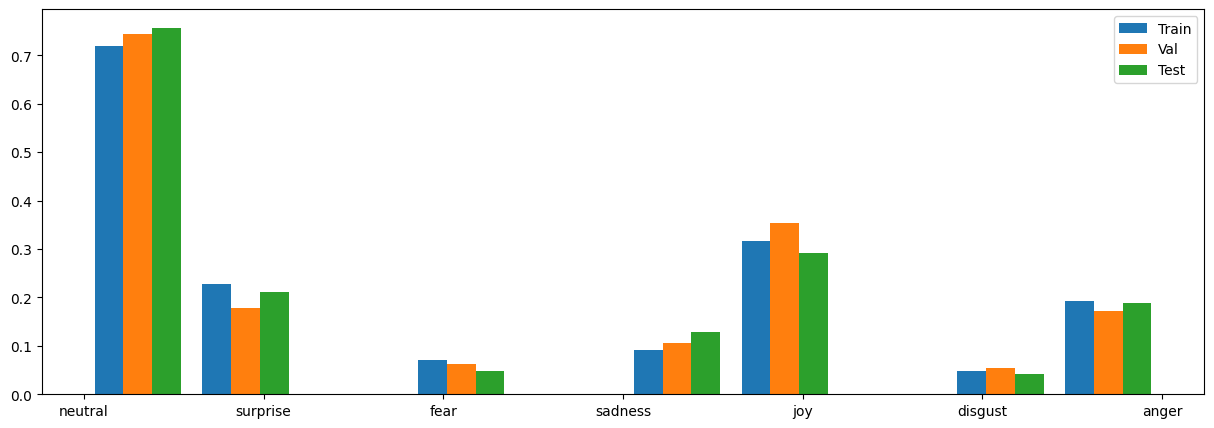

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.hist([df_train.emotion, df_val.emotion, df_test.emotion],
                density=True,
                label=["Train", "Val", "Test"],
                histtype="bar",
                )
plt.legend()
plt.show()

<ipython-input-198-b411e58f02d7>:4: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  df_rep_emotion.plot(x="label", y="f1-score", kind="bar", sort_columns=True)


<Figure size 1500x200 with 0 Axes>

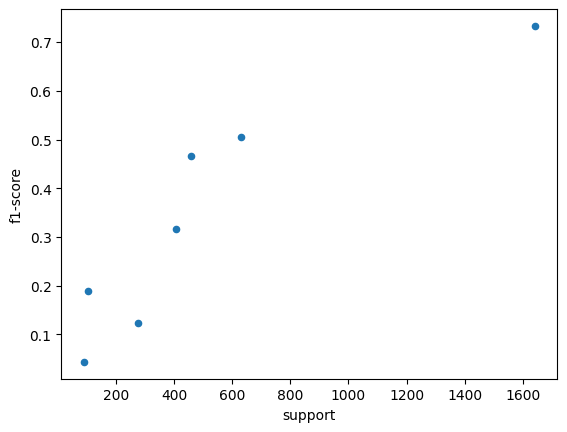

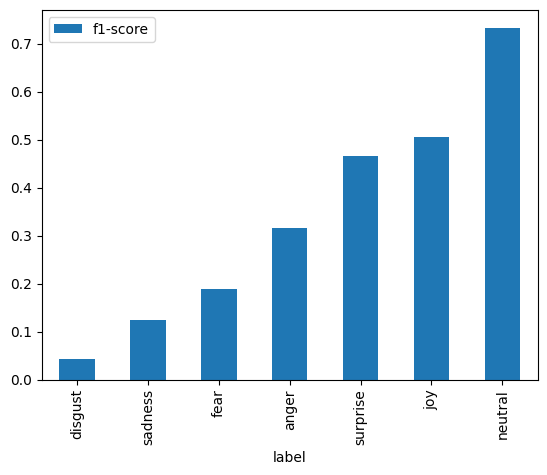

In [ ]:
plt.figure(figsize=(15,2))
df_rep_emotion.plot.scatter(x="support", y="f1-score")
df_rep_emotion.sort_values("f1-score", inplace= True)
df_rep_emotion.plot(x="label", y="f1-score", kind="bar", sort_columns=True)
plt.show()

### Confusion Matrix

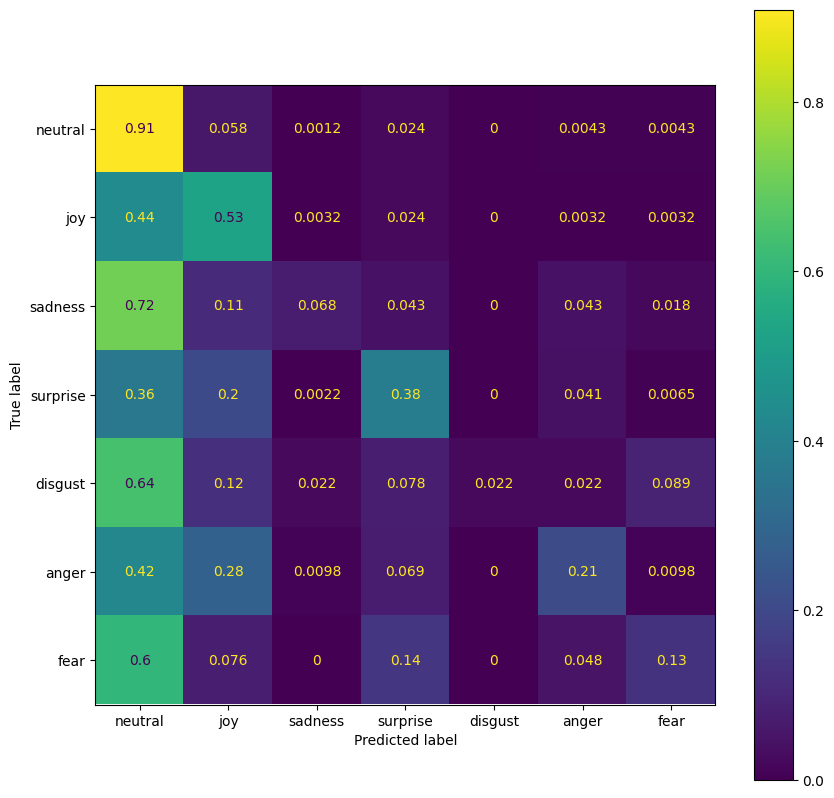

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cm_disp.plot(ax=ax)

### Triggers error

In [ ]:
df_report_tri, cm_disp = get_report(df_test, 'tri')

In [ ]:
df_report_tri

,f1-score,support,encoded_label,label
0,0.910714,3043.0,0,0.0
1,0.042208,569.0,1,1.0


The trigger for its nature is quite rare in the dataset and it requires a deeply understanding of the meaning of the sentence. So it doesn't surprise to see that's it's more difficult for the model to be identified.

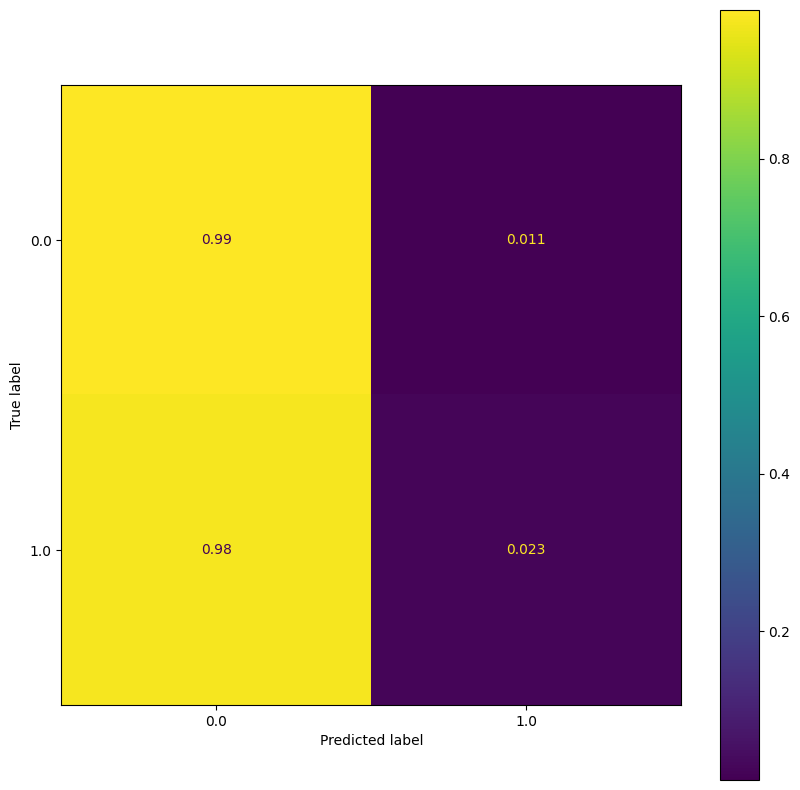

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cm_disp.plot(ax=ax)

For the triggers analysis, it could be usefull to observe if there are emotion for which an error is more frequent

First of all, let's show the frequence of triggers related to the emotion

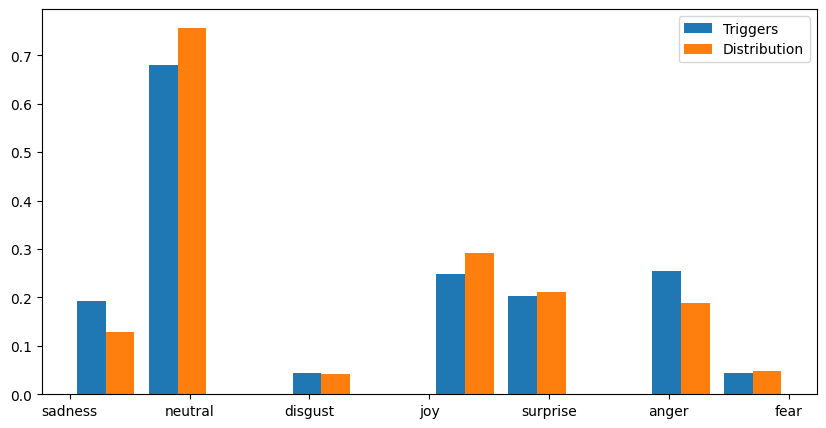

In [ ]:
df_report_tri = df_test[df_test["labtri"] == 1]
plt.figure(figsize=(10,5))
plt.hist([df_report_tri.emotion, df_test.emotion],
                density=True,
                label=["Triggers", "Distribution"],
                histtype="bar",
                )

plt.legend()
plt.show()

The triggers are well distributed among the emotions.

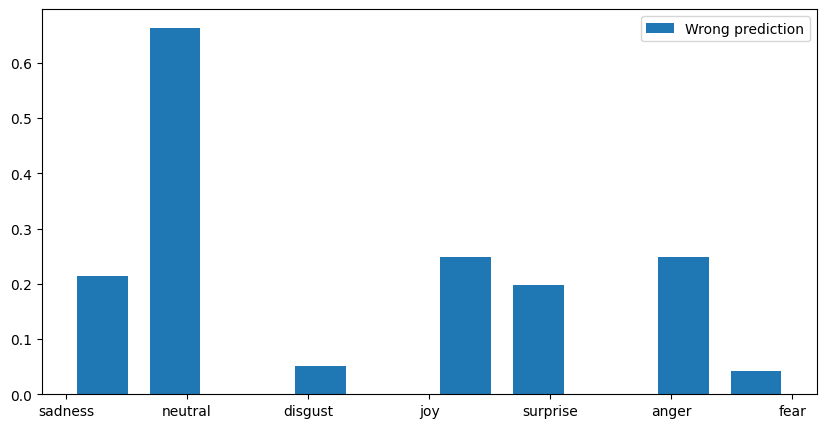

In [ ]:
df_report_tri = df_test[df_test["labtri"] != df_test["predicted_tri"]]
plt.figure(figsize=(10,5))
plt.hist(df_report_tri.emotion,
                density=True,
                label="Wrong prediction",
                histtype="bar",
                rwidth=0.7
                )
plt.legend()
plt.show()

From the showed graph, is possible to see that the model fails the most to undestand the trigger when it's caused by a neutral sentence.